<center><h1>Time series analysis</h1></center>
<center><h2>Tutorial 3: Holt-Winters exponential smoothing</h2></center>
<br>

In this tutorial we will study how to apply exponential smoothing methods to forecast seasonal data in Python. 

<a class="buttom" href=">#Data:-NSW-retail-turnover">Data: NSW retail turnover</a> <br>
<a class="buttom" href="#Time-series-decomposition">Time series decomposition</a> <br>
<a class="buttom" href="#Trend-corrected-exponential-Smoothing">Trend corrected exponential smoothing</a> <br>
<a class="buttom" href="#Hold-Exponential-Smoothing">Holt-Winters smoothing</a> <br>
<a class="buttom" href="#Model-diagnostics">Model diagnostics</a> <br>
<a class="buttom" href="#Model-validation">Model validation</a> <br>
<a class="buttom" href="#Forecast">Forecast</a> <br>

Based in the work of Marcel Scharth http://www.marcelscharth.com/

This notebook relies on the following imports and settings

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

## Data: NSW Retail turnover

In this tutorial we will keep working with the Australian retail turnover series. The next cells load the data and reproduces some of the steps from last week. 

In [4]:
data = pd.read_csv('datasets/nswretail.csv', index_col='Month', parse_dates=True, dayfirst=True)
data.tail()

,Turnover
Month,
2018-05-01,8438.3
2018-06-01,8354.4
2018-07-01,8304.6
2018-08-01,8474.8
2018-09-01,8387.7


In [5]:
y = data['Turnover'].copy()
y.index = y.index.to_period(freq='M')

ts = data['Turnover']

In [6]:
data.describe().round(2)

,Turnover
count,438.00
mean,4335.57
std,2164.08
min,1214.50
25%,2566.80
50%,3930.70
75%,5986.15
max,10960.70


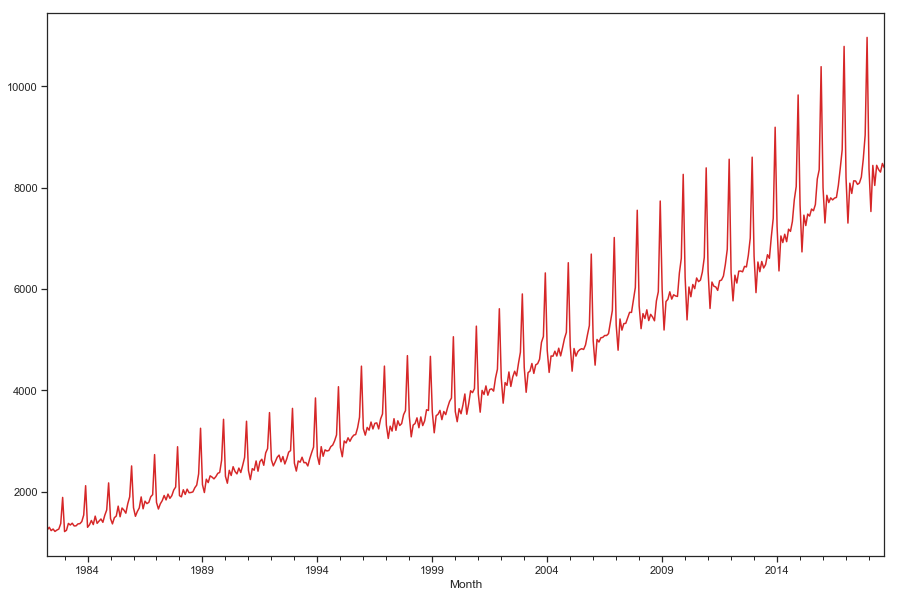

In [7]:
y.plot(color=red);#figsize=(9,6))

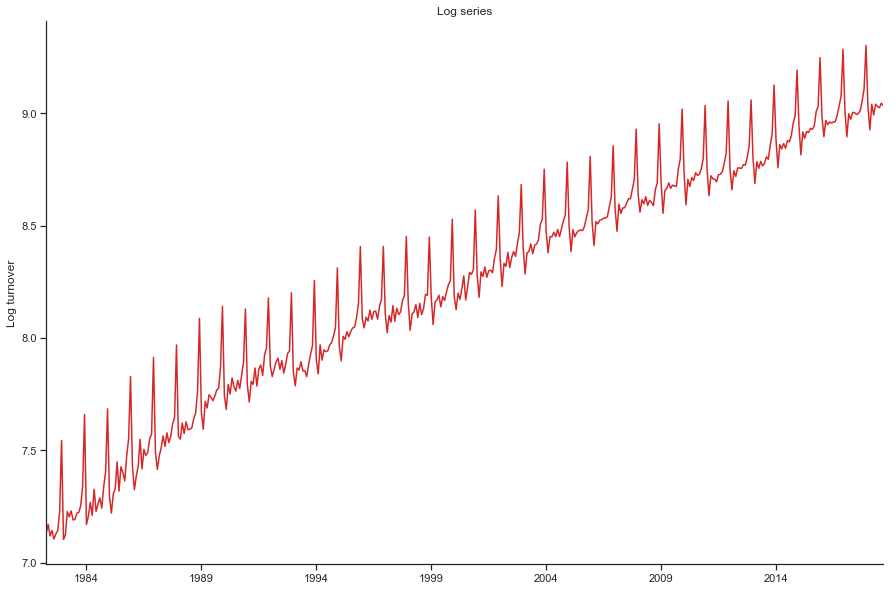

In [8]:
fig, ax= plt.subplots();#figsize=(9,6))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log turnover')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Time series decomposition

We use the X-13 ARIMA-SEATS method for time series decomposition. The X-13 method is a state-of-art time series decomposition approach developed and provided by the [US Census Bureau](https://www.census.gov/srd/www/x13as/) as external software. You need to make the X-13 software available to Python by downloading it from the link and extracting the compressed folder to your computer. The <TT>statsmodels</TT> library has a function that interfaces with this software, and the easiest way to get it to work is to copy the <TT>x13as</TT> executable to the same folder as your notebook.  

The X-13 is the current version of the X-12-ARIMA method described in the [textbook](https://www.otexts.org/fpp/6/4). The only limitation is that the X-13 software makes calendar effect adjustments based on the US calendar by default, though it is possible to reconfigure it to other calendars. Refer to the [ABS](http://abs.gov.au/websitedbs/d3310114.nsf/4a256353001af3ed4b2562bb00121564/c890aa8e65957397ca256ce10018c9d8) for the seasonal adjustment standards in Australia.  

In Linux you can use `get-x13as.sh` to get it.

In [9]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')

/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


You can use the <TT>dir</TT> method to check the available output. 

In [10]:
dir(decomposition)[-6:]

['observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

For example, if we want to retrieve and plot the seasonally adjusted component, we can do as follows.

In [11]:
decomposition.seasadj.tail()

Month
2018-05-01    8685.001859
2018-06-01    8678.781774
2018-07-01    8651.566337
2018-08-01    8804.640295
2018-09-01    8621.053459
Name: seasadj, dtype: float64

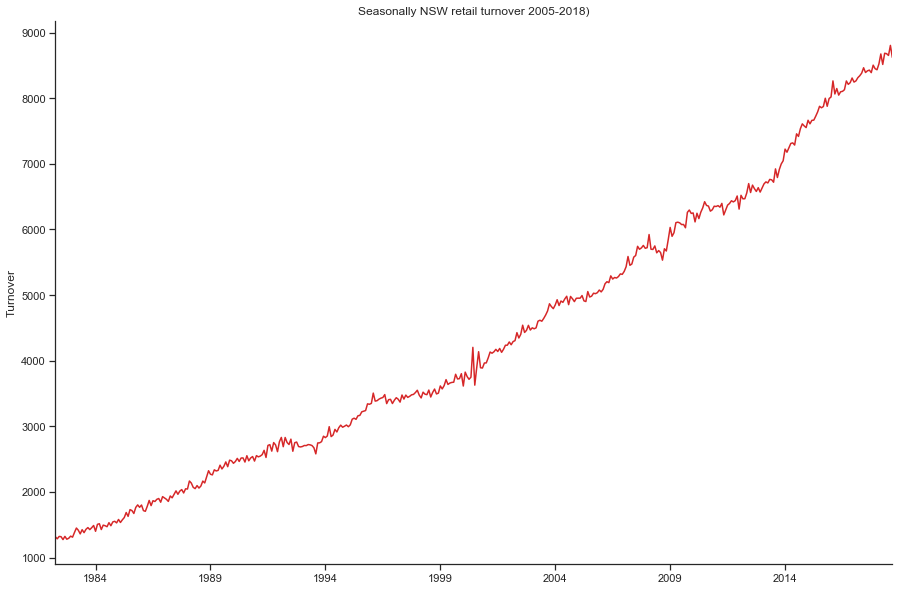

In [12]:
fig, ax= plt.subplots();#figsize=(9,6))
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Seasonally NSW retail turnover 2005-2018)')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

The <TT>plotting</TT> module has a convenient function for plotting the components. 

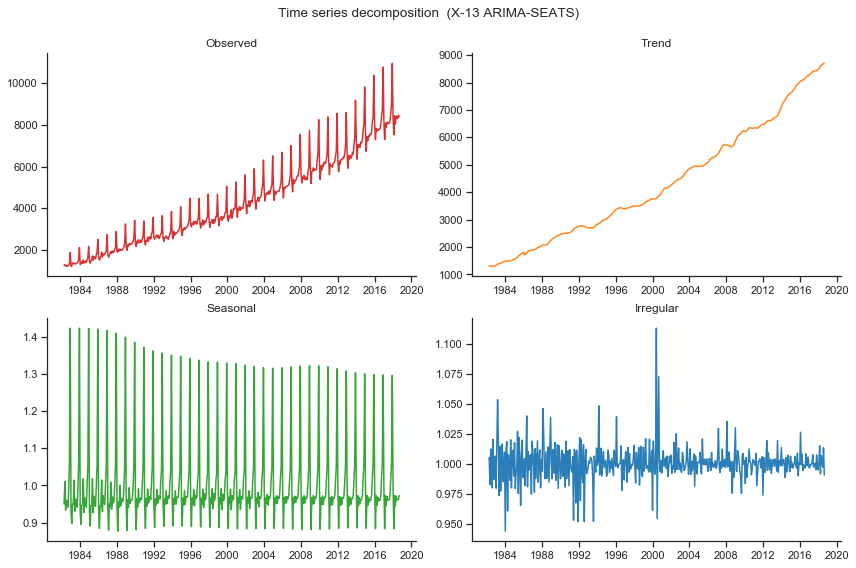

In [13]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

The X-13-ARIMA software generates a very detailed analysis of the time series, which is stored in the <TT>results</TT> attribute. You can view it with the <TT>print(decomposition.results)</TT> command, but due to the length I recommend saving it to a text file and opening it elsewhere. You can do this as follows.  

In [14]:
f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

In case you are not able to work with the X13 decomposition software, a more basic decomposition is available as follows.

In [15]:
basic_decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')

## Trend corrected exponential smoothing

Before we model and forecast the original series, the next cells demonstrate the application of the trend corrected exponential smoothing method, focusing on the seasonally adjusted series for coherence. 

In [16]:
ts=decomposition.seasadj
ts.index=ts.index.to_period(freq='M')

In [17]:
model_sm = sm.tsa.Holt(ts).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_sm))

 Smoothing parameter: alpha  0.424
 Smoothing parameter: betha  0.016
 In-sample fit:
 MSE               5083.849


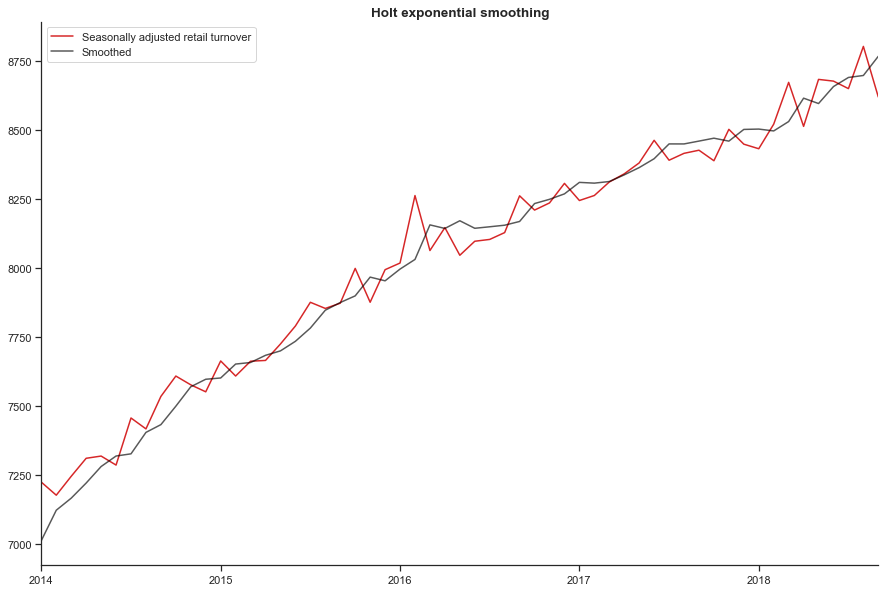

In [18]:
#smoothed=pd.Series(smoothed_sm, index=ts.index)

fig, ax= plt.subplots();#figsize=(9,6))

ts['2014':].plot(color='#D62728', label='Seasonally adjusted retail turnover')
smoothed_sm['2014':].plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

/opt/anaconda/3/envs/tempseries/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


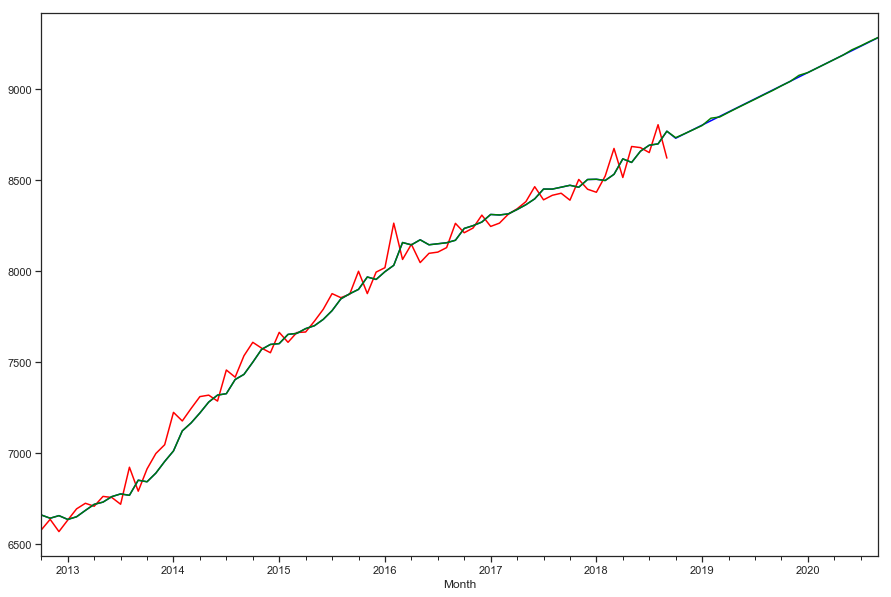

In [19]:
h=24
w=h*3
data = ts
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

## Holt-winters exponential smoothing

We estimate several candidate specifications below.  The AIC suggests a multiplicative model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation. 

In [20]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return rmse_sm

In [21]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=12).fit()

In [22]:
hw_summary(ahw_sm);

 Smoothing parameter: alpha  0.351
 Smoothing parameter: betha  0.012
 Smoothing parameter: delta  0.596
 In-sample fit:
 MSE               8785.646
 RMSE               93.732


In [23]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm);

 Smoothing parameter: alpha  0.364
 Smoothing parameter: betha  0.011
 Smoothing parameter: delta  0.239
 In-sample fit:
 MSE               7326.962
 RMSE               85.598


In [24]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped);

 Smoothing parameter: alpha  0.367
 Smoothing parameter: betha  0.014
 Smoothing parameter: delta  0.241
 In-sample fit:
 MSE               7360.502
 RMSE               85.793


The smoothed series based on the multiplicative method tracks the original series very closely.

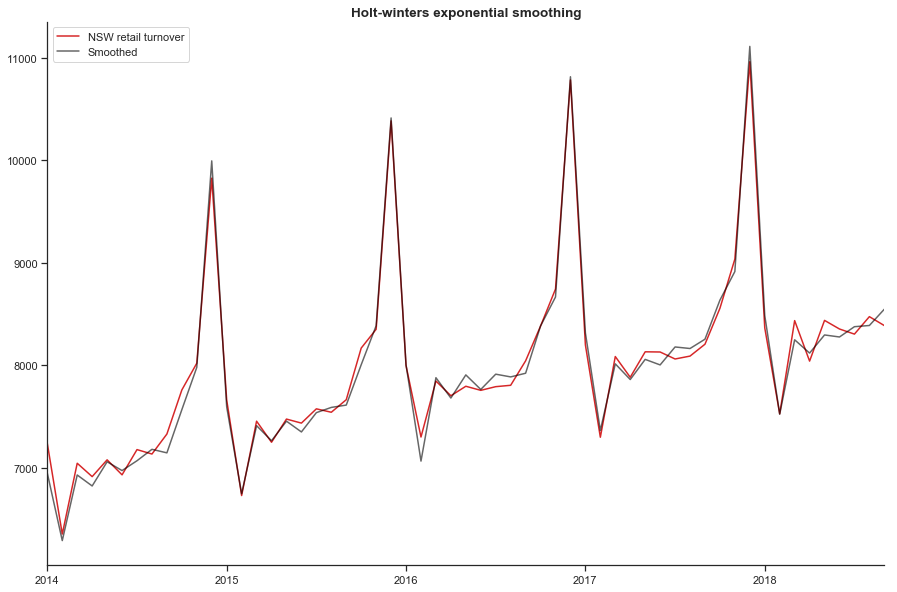

In [25]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots();#figsize=(9,6))

y['2014':].plot(color='#D62728', label='NSW retail turnover')
smoothed['2014':].plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Model diagnostics

We base the diagnostics on the multiplicative Holt-Winters model.  The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals. 

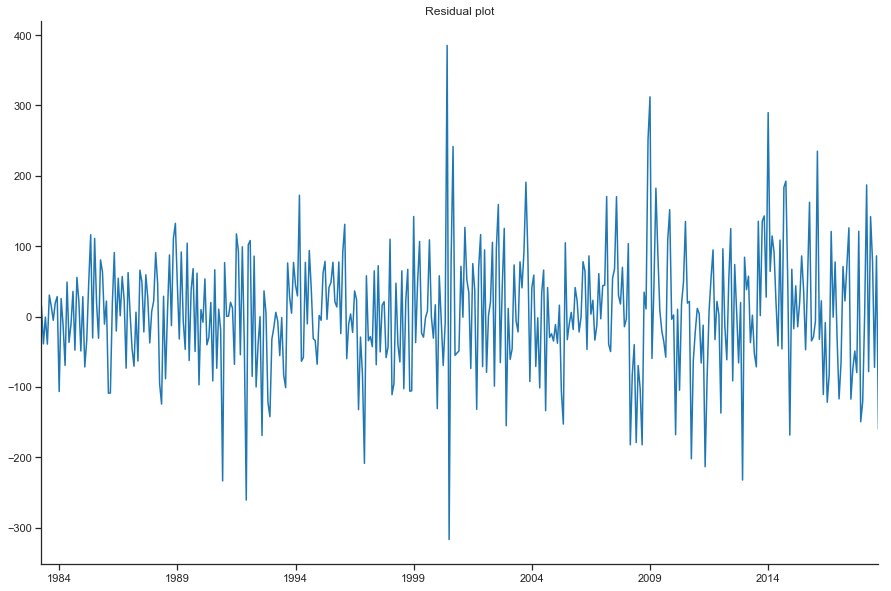

In [26]:
resid = (y-mhw_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

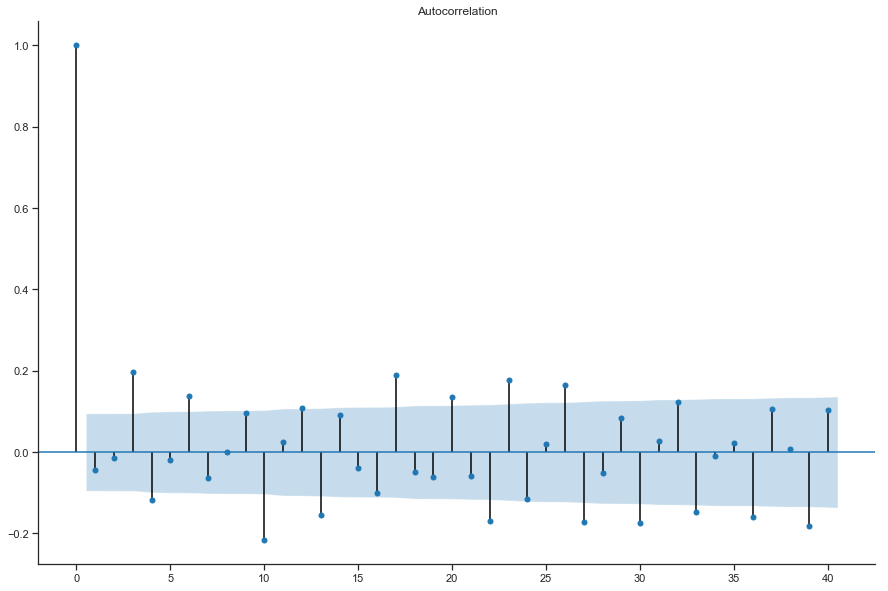

In [27]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

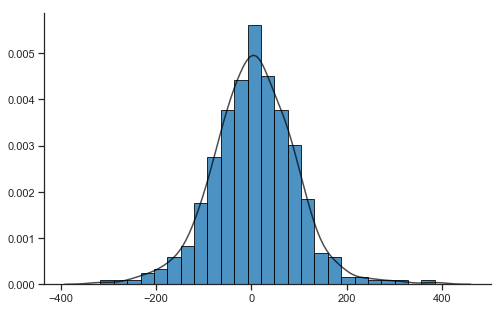

In [28]:
from plotting import histogram

histogram(resid)
plt.show()


## Model validation

The real time forecasting analysis suggests that the log additive Holt Winters model for the log series is the most accurate method for one step ahead forecasts. The Holt-Winters forecasts perform significantly better than a seasonal random walk. 

In [29]:
start_val = y.index[-round(len(y)/12*.2)*12]
start_val

Period('2011-10', 'M')

In [30]:
# Real time forecasting 

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [31]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,359.155,18.131
Additive,109.140,11.793
Multiplicative,100.295,10.917


## Forecast

Finally, we generate a two year forecast based on the selected model. 

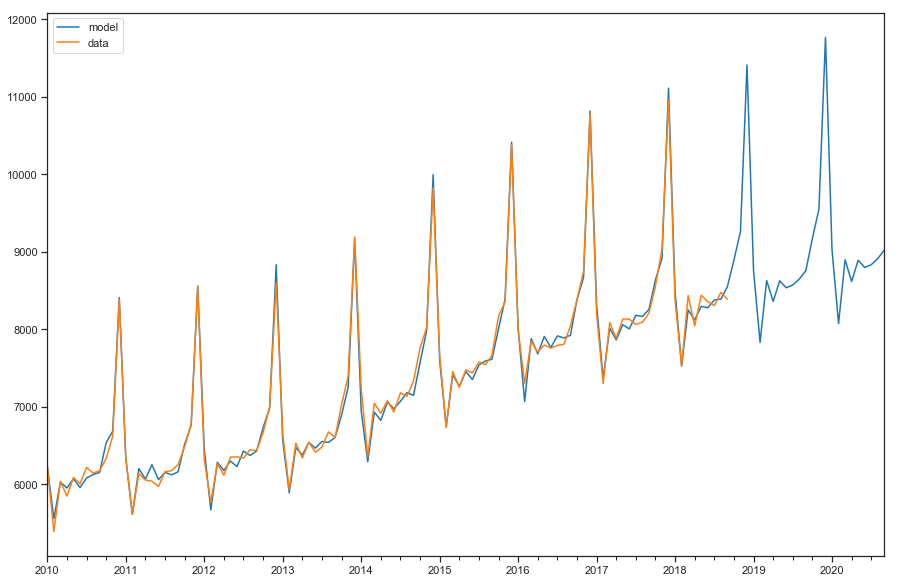

In [32]:
h=24

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['model'] = pd.concat([model.fittedvalues, forecast])
plot['data'] = y
#pd.Series(model.fittedvalues + model.fcastvalues), 
#                         index=pd.period_range(y.index[0],y.index[-1]+h,freq=y.index.freq))

plot['2010':].plot();#figsize=(9,6))